In [1]:
import sys
sys.path.append("../")

In [2]:
from utils.common_train_utils import *
from utils.draw_candle_image import *
from utils.evaluate_old_models import *
from functools import partial
from model_code import *
from attention_model import *
from ta import add_all_ta_features
from ta.utils import dropna
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import inspect
import random

2024-12-12 10:15:50.843360: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 10:15:50.869565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 10:15:50.885547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 10:15:50.889300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 10:15:50.900316: I tensorflow/core/platform/cpu_feature_guar

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1733998552.967660  381677 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733998553.033755  381677 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733998553.033805  381677 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
print(logdir)

/tmp/tmpzu2hx_n6/tensorboard_logs


In [6]:
symbol = input("symbol = ").strip().lower()

In [7]:
dataset_folder = f"../dataset/{symbol}_with_three_image_ema_macd"

In [8]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [9]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)

I0000 00:00:1733998554.637153  381677 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733998554.637224  381677 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733998554.637237  381677 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733998554.768682  381677 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733998554.768808  381677 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-12

In [10]:
dataset_train = load_dataset_of_each_type_and_combine(f"{dataset_folder}/train", candle_type_and_directory_save)
total_data_train = len(dataset_train)

In [11]:
def image_time_series(image_shape, days_result, units=128):
    image_time_series_model = CNNAttention(units)
    
    return image_time_series_model, "cnn_attention"

In [12]:
UNITS = 256
function_transform_origin = get_open_close_prices_percent_of_last_days_result_for_three_image_dataset
model_function = image_time_series
image_shape = get_image_shape(dataset_train, index_of_image=0)
model, model_name = model_function(image_shape, days_result)

In [13]:
# batch_size = 2**int(input("batch_size = 2^x, x = ").strip())
batch_size = int(input("batch_size = ").strip())
STEPS_PER_EPOCH = total_data_train // batch_size + 1
name_sub_folder_save_metrics = f"{model_name}_{os.path.basename(dataset_folder)}"
name_folder_save_metrics = f"sizes/{model_name}_{os.path.basename(dataset_folder)}"
max_epochs = int(input(f"max_epochs = "))
metric_mae_name = "mae"
metric_mae_object = keras.metrics.MeanAbsoluteError(name=metric_mae_name)
metric_mse_name = "mse"
metric_mse_object = keras.metrics.MeanSquaredError(name=metric_mse_name)
val_loss_metric_mae_to_stop = float(input("val_loss_metric_mae_to_stop = "))
val_loss_metric_mse_to_stop = float(input("val_loss_metric_mse_to_stop = "))
start_learning_rate = float(input("start_learning_rate = ").strip())
shuffle_buffer = 300
number_epochs_to_decrease_lr = int(input("number_epochs_to_decrease_lr = "))
number_epochs_to_wait = int(input("number_epochs_to_wait = "))

In [14]:
print(f"2^{np.log2(batch_size)}")
print(f"{batch_size=}")
print(f"{max_epochs=}")
print(f"{start_learning_rate=}")
print(f"{STEPS_PER_EPOCH=}")
print(f"{val_loss_metric_mae_to_stop=}")
print(f"{val_loss_metric_mse_to_stop=}")
print(f"{number_epochs_to_decrease_lr=}")
print(f"{number_epochs_to_wait=}")

2^1.584962500721156
batch_size=3
max_epochs=100
start_learning_rate=0.1
STEPS_PER_EPOCH=839
val_loss_metric_mae_to_stop=-1.0
val_loss_metric_mse_to_stop=-1.0
number_epochs_to_decrease_lr=10
number_epochs_to_wait=20


In [15]:
model_name

'cnn_attention'

In [16]:
(total_data_train, total_data_test)

(2515, 64)

In [17]:
dataset_train_1 = dataset_train.shuffle(shuffle_buffer)
dataset_test_1 = dataset_test.shuffle(shuffle_buffer)

dataset_train_2 = dataset_train_1.batch(batch_size)
dataset_test_2 = dataset_test_1.batch(batch_size)

transform_function = partial(function_transform_origin, days_result)
dataset_train_3 = dataset_train_2.map(transform_function)
dataset_test_3 = dataset_test_2.map(transform_function)

In [18]:
# for item in dataset_test_2:
#     print(item[0].shape)
#     print(item[1].shape)
#     print(item[2].shape)
#     print(item[3].shape)
#     print(item[4].shape)
#     print(item[5].shape)
#     print(item[6].shape)
    
#     item = None
#     break

In [19]:

# for (
#         list_images_30_days,
#         list_images_7_days,
#         list_images_3_days,
#         percent_change_of_open_close_in,
#     ), percent_change_of_open_close_out in dataset_train_3:
#     print(list_images_30_days.shape)
#     print(list_images_7_days.shape)
#     print(list_images_3_days.shape)
#     print(percent_change_of_open_close_in.shape)
#     print(percent_change_of_open_close_out.shape)
    
#     list_images_30_days = None
#     list_images_7_days = None
#     list_images_3_days = None
#     percent_change_of_open_close_in = None
#     percent_change_of_open_close_out = None
#     break

In [20]:
# for features, labels in dataset_train_3.take(1):
#     print(features[0].shape)
#     print(features[1].shape)
#     print(labels.shape)

In [21]:
# for (
#         list_images_30_days,
#         list_images_7_days,
#         list_images_3_days,
#         percent_change_of_open_close_in,
#     ), percent_change_of_open_close_out in dataset_test_3:
#         print(list_images_30_days.shape)
#         print(list_images_7_days.shape)
#         print(list_images_3_days.shape)
#         print(percent_change_of_open_close_in.shape)
#         print(percent_change_of_open_close_out.shape)
#         break

In [22]:
(len(dataset_train_3), len(dataset_test_3))

(839, 22)

In [23]:
class StopAtLossValue(keras.callbacks.Callback):
    def __init__(self, target_loss, metric_name):
        super(StopAtLossValue, self).__init__()
        self.target_loss = target_loss
        self.metric_name = metric_name

    def on_epoch_end(self, epoch, logs=None):
        # Lấy giá trị loss từ logs
        current_loss = logs.get(f"val_{self.metric_name}")
        if current_loss is not None and current_loss <= self.target_loss:
            print(f"\nĐạt target loss = {self.target_loss}, dừng training tại epoch {epoch + 1}")
            self.model.stop_training = True


class SaveModelCallback(keras.callbacks.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        folder_tmp = f"{self.save_path}/tmp_model"
        file_name = f"{folder_tmp}/model_tmp_{epoch}.keras"
        self.model.save(file_name)  # Lưu toàn bộ model
        

class TrackingLossCallback(keras.callbacks.Callback):
    def __init__(self, metric_mse_name, metric_mae_name):
        super().__init__()
        self.list_epochs = []
        self.list_val_mse_loss = []
        self.list_train_mse_loss = []
        self.list_val_mae_loss = []
        self.list_train_mae_loss = []
        self.metric_mse_name = metric_mse_name
        self.metric_mae_name = metric_mae_name
        self.val_mse_loss_key = f"val_{self.metric_mse_name}"
        self.train_mse_loss_key = f"{self.metric_mse_name}"
        self.val_mae_loss_key = f"val_{self.metric_mae_name}"
        self.train_mae_loss_key = f"{self.metric_mae_name}"

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        self.list_epochs.append(epoch)
        self.list_val_mse_loss.append(logs.get(self.val_mse_loss_key))
        self.list_train_mse_loss.append(logs.get(self.train_mse_loss_key))
        self.list_val_mae_loss.append(logs.get(self.val_mae_loss_key))
        self.list_train_mae_loss.append(logs.get(self.train_mae_loss_key))
    
    def get_df_result(self):
        df = pd.DataFrame({
            "epoch": self.list_epochs,
            self.val_mse_loss_key: self.list_val_mse_loss,
            self.train_mse_loss_key: self.list_train_mse_loss,
            self.val_mae_loss_key: self.list_val_mae_loss,
            self.train_mae_loss_key: self.list_train_mae_loss,
        })
        df.sort_values(self.val_mse_loss_key, inplace=True)
        return df

In [24]:
def get_optimizer(start_learning_rate, number_epochs_to_decrease_lr):
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
        start_learning_rate,
        decay_steps=STEPS_PER_EPOCH*number_epochs_to_decrease_lr,
        decay_rate=1,
        staircase=False
    )
    
    return keras.optimizers.Adam(lr_schedule)

tracking_loss_callback = TrackingLossCallback(metric_mse_name, metric_mae_name)
def get_callbacks(name, metric_name, number_epochs_to_wait):
    return [
        tfdocs.modeling.EpochDots(),
        StopAtLossValue(val_loss_metric_mae_to_stop, metric_mae_name),
        StopAtLossValue(val_loss_metric_mse_to_stop, metric_mse_name),
        SaveModelCallback(dataset_folder),
        tracking_loss_callback,
        keras.callbacks.EarlyStopping(monitor=f'val_loss', patience=number_epochs_to_wait),
        keras.callbacks.TensorBoard(logdir/name)
    ]
  
  
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(start_learning_rate, number_epochs_to_decrease_lr),
    metrics=[
        metric_mae_object,
        metric_mse_object
    ],
)


In [25]:
# # Ví dụ
# all_models_folder_path = os.path.join(os.path.abspath(dataset_folder), "model_save")
# evaluate_all_models_in_dataset_folder(
#     all_models_folder_path, 
#     dataset_test_2,
#     days_result
# )

In [ ]:
# Ví dụ
all_models_folder_path = os.path.join(os.path.abspath(dataset_folder), "model_save")
evaluate_all_models_in_dataset_folder(
    all_models_folder_path, 
    dataset_test_2,
    days_result
)

,model_name,mse,mae


In [25]:
is_start_train = input("Start train? (y/n): ").lower()[0] == "y"
if is_start_train:
    folder_tmp = f"{dataset_folder}/tmp_model"
    os.makedirs(folder_tmp, exist_ok=False)
    history = model.fit(
        dataset_train_3, 
        validation_data=dataset_test_3,
        epochs=max_epochs, 
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=get_callbacks(name_folder_save_metrics, metric_mse_name, number_epochs_to_wait)
    )

In [28]:
# reloaded = tf.saved_model.load(f'{dataset_folder}/cnn_attention')

# reloaded.predict_next_3_days_prices(
    
#     tf.cast(list_images_7_days, dtype=tf.float64),
#     tf.cast(list_images_3_days, dtype=tf.float64),
#     tf.cast(percent_change_of_open_close_start, dtype=tf.float64)
    
# )

In [29]:
def get_folder_path_to_save_model(model_name):
    new_model_name = model_name
    path_save = f"{dataset_folder}/model_save/{new_model_name}"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        random_index = random.randint(0, 100)
        new_model_name = new_model_name + f"_{random_index}"
        path_save = f"{dataset_folder}/model_save/{new_model_name}"
        print(f"-- Change to {path_save}")
    os.makedirs(path_save, exist_ok=False)
    return path_save, new_model_name 

In [30]:
def save_model(model: keras.Sequential, folder_path, new_model_name):
    path_save = f"{folder_path}/{new_model_name}.keras"
    abspath_save = os.path.abspath(path_save)
    model.save(abspath_save)
    return path_save

In [31]:
def save_model_and_config(model: keras.Sequential, epoch):
    folder_path, new_model_name = get_folder_path_to_save_model(f"{model_name}_epoch_{epoch}")
    model_name_saved = save_model(model, folder_path, new_model_name)
    # loss = model.evaluate(dataset_test_3)
    loss = 0
    config_and_loss = {
        "config": {
            "batch_size": batch_size,
            "STEPS_PER_EPOCH": STEPS_PER_EPOCH,
            "name_sub_folder_save_metrics": name_sub_folder_save_metrics,
            "name_folder_save_metrics": name_folder_save_metrics,
            "max_epochs": max_epochs,
            "val_loss_metric_mae_to_stop": val_loss_metric_mae_to_stop,
            "val_loss_metric_mse_to_stop": val_loss_metric_mse_to_stop,
            "start_learning_rate": start_learning_rate,
            "shuffle_buffer": shuffle_buffer,
            "number_epochs_to_decrease_lr": number_epochs_to_decrease_lr,
            "number_epochs_to_wait": number_epochs_to_wait,
            "model_function": function_transform_origin.__name__,
            "time_created": str(datetime.now()),
            "epoch": epoch
        },
        "loss": {
            "val_mse_loss": loss[0],
            "val_mae_loss": loss[1],
        }
    }
    with open(f"{folder_path}/config_and_loss.json", "w") as file:
        json.dump(config_and_loss, file, indent=2)
    code_str = inspect.getsource(model_function)
    with open(f"{folder_path}/model_function_code.py", "w", encoding="utf8") as file:
        file.write(code_str)
    
    return new_model_name

In [32]:
list_name_models = []
list_models = []
df_result = tracking_loss_callback.get_df_result()

In [ ]:
df_result

,epoch,val_mse,mse,val_mae,mae
2,2,3.822068,8.246103,1.427801,1.831077
4,4,4.396814,8.623116,1.537701,1.850074
5,5,4.573303,8.119316,1.550434,1.802723
1,1,4.741016,8.803377,1.606000,1.873016
3,3,4.935020,8.534316,1.589564,1.851990
7,7,5.254655,9.401801,1.618985,1.859273
6,6,5.297678,8.506192,1.485072,1.827268
9,9,5.387945,9.071786,1.600184,1.853172
8,8,5.409916,9.186896,1.619191,1.854809
10,10,5.453658,9.005985,1.676938,1.849507


In [34]:
now = datetime.now()
result = now.strftime("%Y-%m-%d %H:%M:%S")
os.makedirs(f"{dataset_folder}/loss_train", exist_ok=True)
df_result.sort_values("epoch").to_excel(f"{dataset_folder}/loss_train/{result}.xlsx", index=False)

In [ ]:
if input("save model? (y/n): ").lower()[0] == "y":
    is_save_model_from_tmp = input("Save model from tmp file? (y/n): ").lower()[0] == "y"
    
    if is_save_model_from_tmp:
        while True and os.path.exists(folder_tmp):
            epoch = input(f"Epoch = (s for stop)")
            if not str.isdigit(epoch):
                break
            else:
                epoch = int(epoch)
            
            model_tmp_name = f"model_tmp_{epoch}.keras"
            print(f"Save {model_tmp_name}")
            model_tmp_path = f"{folder_tmp}/{model_tmp_name}"
            if not os.path.exists(model_tmp_path):
                print(f"model {model_tmp_path} does not exist.")
                continue
            
            try:
                model_tmp = keras.models.load_model(model_tmp_path)
                name_model_tmp_saved = save_model_and_config(model_tmp, epoch)
                list_name_models.append(name_model_tmp_saved)
                list_models.append(model_tmp)
            except Exception as err:
                print(err)
                continue
    
    is_save_last_model = input("Save last model? (y/n): ").lower()[0] == "y"
    if is_save_last_model:
        name_last_model_saved = save_model_and_config(model, "last")
        list_name_models.append(name_last_model_saved)
        list_models.append(model)

is_delete_tmp_model_folder = input("Delete model tmp folder? (y/n): ").lower()[0] == "y"
if is_delete_tmp_model_folder:
    if os.path.exists(folder_tmp):
        shutil.rmtree(folder_tmp)
    else:
        print(f"{folder_tmp} does not exist.")
    

In [36]:
for model_loaded, model_name_loaded in zip(list_models, list_name_models):
    loss = model_loaded.evaluate(dataset_test_3)
    print(f"{model_name_loaded}: {loss}")

In [37]:
size_histories = {}
size_histories[name_sub_folder_save_metrics] = history 

In [38]:
def draw_line(df_result, list_keys, list_labels, title=None):
    list_epochs = df_result["epoch"]
    
    is_need_scale = len(list_keys) == 1
    
    for key, label in zip(list_keys, list_labels):
        list_values = df_result[key]
        
        marker = None
        if is_need_scale:
            marker = "o"
        plt.plot(list_epochs, list_values, label=label, marker=marker)
        
    if is_need_scale:
        min_loss = df_result[list_keys[0]].min()
        max_loss = df_result[list_keys[0]].max()
        scale = (max_loss - min_loss) / 100
        plt.ylim([min_loss - scale, max_loss + scale])
    
    plt.title(title)
    plt.xlabel('Epoch')  # Nhãn trục X
    plt.ylabel('Giá trị mất mát')  # Nhãn trục Y
    plt.axhline(0, color='black', linewidth=0.5)  # Trục ngang
    plt.axvline(0, color='black', linewidth=0.5)  # Trục dọc
    plt.grid(True, linestyle='--', alpha=0.5)  # Thêm lưới
    plt.legend()  # Hiển thị chú thích
    plt.show()

    
    

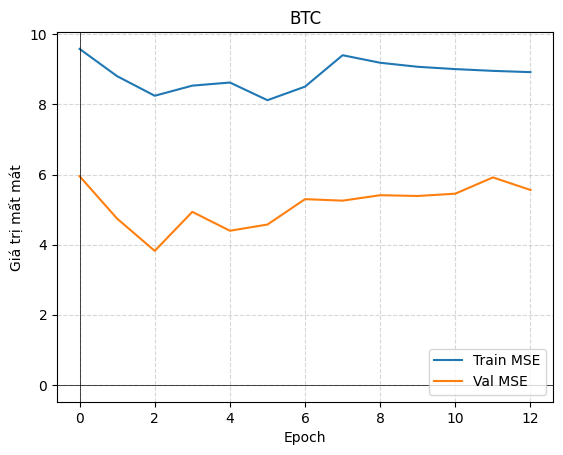

In [ ]:
df_result_to_draw = df_result.sort_values("epoch", ascending=False)

draw_line(
    df_result=df_result_to_draw,
    list_keys=[
        tracking_loss_callback.train_mse_loss_key,
        tracking_loss_callback.val_mse_loss_key,
    ],
    list_labels=[
        "Train MSE",
        "Val MSE",
    ],
    title=f"{symbol.upper()}"
)

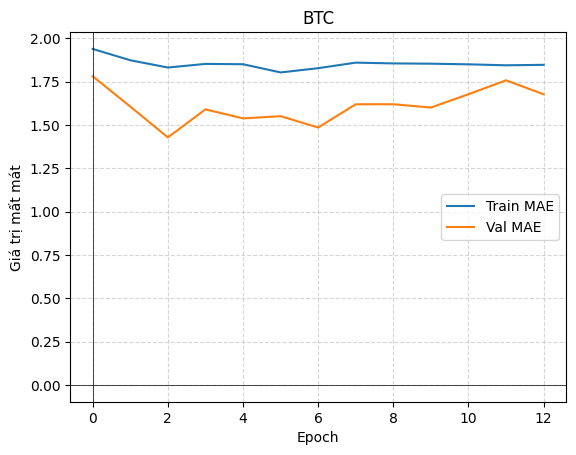

In [ ]:
draw_line(
    df_result=df_result_to_draw,
    list_keys=[
        tracking_loss_callback.train_mae_loss_key,
        tracking_loss_callback.val_mae_loss_key,
    ],
    list_labels=[
        "Train MAE",
        "Val MAE",
    ],
    title=f"{symbol.upper()}"
)

In [41]:
list_name_models

[]

In [42]:
dataset_folder

'../dataset/btc_with_three_image_ema_macd'